<h1>Youtube Comments Sentiment Analysis</h1>

In [61]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import nltk
import os, re, csv
import inspect


import nltk.corpus
from nltk.corpus.reader.plaintext import PlaintextCorpusReader

from nltk.corpus import stopwords 
nltk.download('stopwords')
from nltk.tokenize import word_tokenize 
from collections import Counter

import nltk
nltk.download('punkt')

from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\X\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\X\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\X\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [62]:

merged_comments = pd.read_excel('./merged_comments.xlsx')
channel_topics = pd.read_excel('./yt_channels_topics.xlsx')


In [63]:
print(channel_topics)

              Channels                                        Assad  \
0          right-wing:                                          NaN   
1         Rubin Report                                          NaN   
2          Ben Shapiro  https://www.youtube.com/watch?v=lCh0Sti3Ons   
3       Steven Crowder  https://www.youtube.com/watch?v=EzUkoCRGNnc   
4   Paul Joseph Watson  https://www.youtube.com/watch?v=kmlrt_6MwXY   
5             The Hill                                          NaN   
6            centrist:                                          NaN   
7    Last Week Tonight                                          NaN   
8        Democracy Now  https://www.youtube.com/watch?v=SHHoCFyHzco   
9         David Pakman                                          NaN   
10         Young Turks  https://www.youtube.com/watch?v=89CpGuc73qc   
11          left-wing:                                          NaN   
12      Second Thought                                          NaN   
13    

In [64]:
merged_comments.head()

,User,Comment,Likes,Published At,Time Ago,channel,topic,leaning
0,@joseaugustofigueiredo2796,BBC journalists must go to the doors of Britis...,0,2024-12-17 11:29:42,2024-12-17 11:29:42,bbc,assad,news
1,@AzadBus-h1h,Getting out of hands. It may sound off topic b...,0,2024-12-15 21:38:09,2024-12-15 21:38:09,bbc,assad,news
2,@Emmanuel-n7y,Imperialist go home,0,2024-12-14 08:39:23,2024-12-14 08:39:23,bbc,assad,news
3,@mrb6309,It's like we've seen this movie in the Middle ...,0,2024-12-13 05:23:05,2024-12-13 05:23:05,bbc,assad,news
4,@musadube1647,😂😂😂 how dumb and foolish the Americans and the...,0,2024-12-13 01:29:48,2024-12-13 01:29:48,bbc,assad,news


<h2>Cleaning dataset</h2>

In this step we perform operations of:

- cleaning text data
- dropping inessential columns
- removing NaN rows
- splitting data into separate sets

In [65]:
merged_comments = merged_comments.drop(['User', 'Published At', 'Time Ago'], axis=1)
print(merged_comments.head())

                                             Comment  Likes channel  topic  \
0  BBC journalists must go to the doors of Britis...      0     bbc  assad   
1  Getting out of hands. It may sound off topic b...      0     bbc  assad   
2                                Imperialist go home      0     bbc  assad   
3  It's like we've seen this movie in the Middle ...      0     bbc  assad   
4  😂😂😂 how dumb and foolish the Americans and the...      0     bbc  assad   

  leaning  
0    news  
1    news  
2    news  
3    news  
4    news  


In [66]:
merged_comments = merged_comments.dropna()

In [67]:
print(len(merged_comments))

113266


<h2>Split dataset into multiple subsets based on the topic</h2>

In [68]:
#unique values in the column as a vector or whatever for encoders later
uniqs = merged_comments['topic'].unique()
uniqs

array(['assad', 'ceo', 'depp', 'capitol'], dtype=object)

In [69]:

def splitter(channel: pd.DataFrame) -> pd.DataFrame:
    channel_comments = merged_comments.loc[merged_comments['topic'] == f'{channel}']
    channel_comments = channel_comments.drop(['topic'], axis=1)
    return channel_comments

list_of_names = {}

assad_comments = splitter('assad')
ceo_comments = splitter('ceo')
capitol_comments = splitter('capitol')
depp_comments = splitter('depp')
print(assad_comments.head())
print(assad_comments.dtypes)
print(depp_comments.head())

                                             Comment  Likes channel leaning
0  BBC journalists must go to the doors of Britis...      0     bbc    news
1  Getting out of hands. It may sound off topic b...      0     bbc    news
2                                Imperialist go home      0     bbc    news
3  It's like we've seen this movie in the Middle ...      0     bbc    news
4  😂😂😂 how dumb and foolish the Americans and the...      0     bbc    news
Comment    object
Likes       int64
channel    object
leaning    object
dtype: object
                                                Comment  Likes channel leaning
5268  Absolutely disgusting so called "journalism". ...      0     cnn    news
5269  Anyone who respects left-wing media should wat...      0     cnn    news
5270  CNN reporting is biased. Salute to USA justice...      0     cnn    news
5271  Amber Tu*d,was a se* worker,had affa*rs, with ...      0     cnn    news
5272  Believe all women, every day, all day and twic...      0 

In [70]:
# replace special characters from text. 
# substituting "/", "@" and "|" and others by a space.

list_of_names = [assad_comments, depp_comments, capitol_comments, ceo_comments]

def cleaner(comments_clean: list):
    for x in comments_clean: 
        x = x.replace('[^a-zA-Z0-9 \n\.]', '', regex=True)
        #x = x.str.lower()

cleaner(list_of_names)
assad_comments['Comment'] = assad_comments['Comment'].str.lower()
ceo_comments['Comment'] = ceo_comments['Comment'].str.lower()
capitol_comments['Comment'] = capitol_comments['Comment'].str.lower()
depp_comments['Comment'] = depp_comments['Comment'].str.lower()

print(ceo_comments.head())

                                                Comment  Likes channel leaning
3237  well he was stressed out so of course he went ...      0     cnn    news
3238  police were  being  forceful  with him .  luig...      0     cnn    news
3239                       nullify nullify \nfree luigi      0     cnn    news
3240                         i am sad!! wish him well!!      0     cnn    news
3241                            hope we can save luigi.      0     cnn    news


In [71]:
ceo_comments['Likes']\
.unique()

array([   0,    2,    1,    3,    9,    4,    8,    5,   73,   22,   15,
         18,   10,  130,   53,  137,   14,   36,  153,   16,   19,    6,
         24,  281,    7,   43,  155,   12,   28,  198,   21,   42,  320,
         72,   31,  535,  224,   68,   25,  141,   62,   11,  181,   30,
         26,  215,  270,   63,  128,  790,   35,   87,   27,  227,  147,
        196,   52, 1184,   66,   34,  355,   47,   69,  203,  616,   20,
        622,  100,  856,  326,  286,  225,   45,  161,   29,  273,  347,
         67,  156,  105,  195,   38,  104,   48,  604,  127,   50,   13,
       2308,  117,  138,  480, 2260,  318,   39,  970,   76,  316, 3191,
       1898,  264,  660,  851,  385,  167,  282,  525,  748,  556,   37,
        208,   77,   23,   92,   44,   80,   65,  184,  640,  157, 1847,
        378,   32,  268,  499,  179, 1013,  862, 2695,  103,  135,  345,
         54,  114,  115,  375,  432, 1985,   51, 1000, 3507, 1949,   91,
         17,  457,   79,  794,  182, 1117,  221, 18

<h2>Text Clustering</h2>

Clustering Stage consists of dividing text data into Vectors and Clusters. We perform this operations for each comments section.

In [72]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(assad_comments['Comment'])
text_Assad = tfidf.transform(assad_comments['Comment'])
text_ceo = tfidf.transform(ceo_comments['Comment'])
text_capitol = tfidf.transform(capitol_comments['Comment'])
text_depp = tfidf.transform(depp_comments['Comment'])

C:\Users\X\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


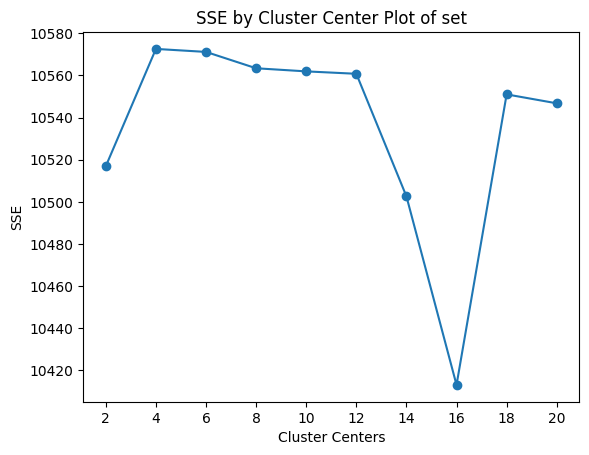

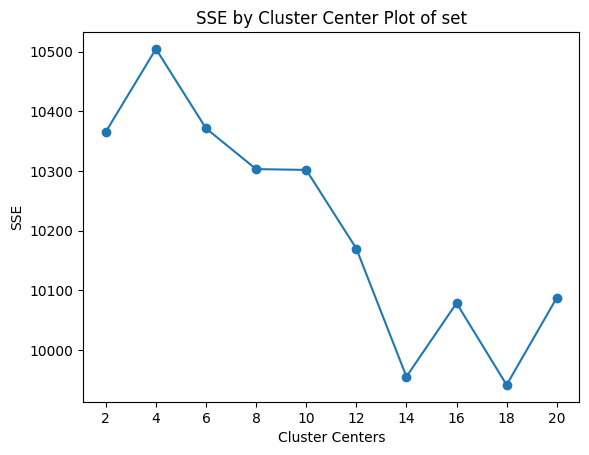

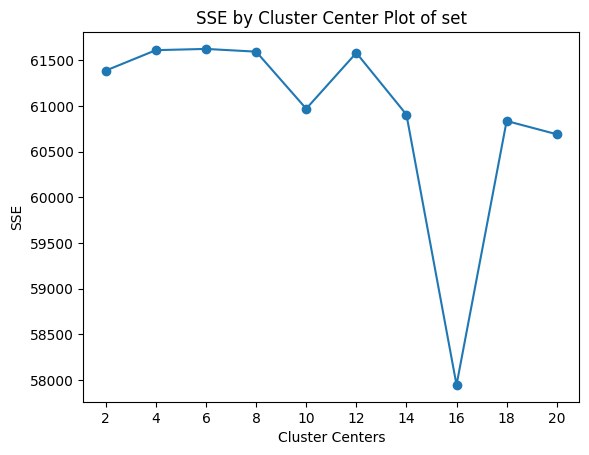

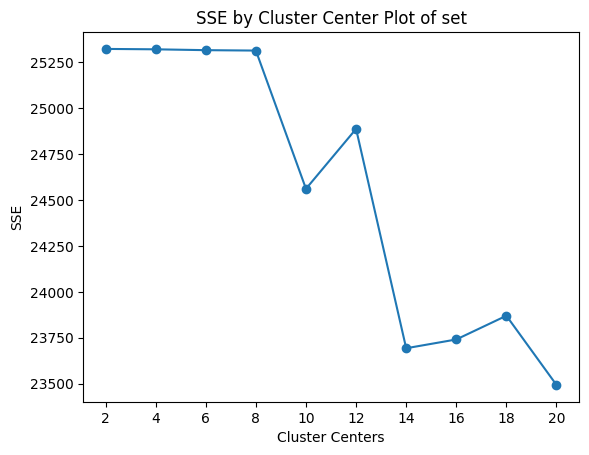

In [73]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title(f'SSE by Cluster Center Plot of set')
    
find_optimal_clusters(text_Assad, 20)
find_optimal_clusters(text_ceo, 20)
find_optimal_clusters(text_capitol, 20)
find_optimal_clusters(text_depp, 20)

In [74]:
# set k to 6
clusters_assad = MiniBatchKMeans(n_clusters=6, init_size=1024, batch_size=2048, random_state=20).fit_predict(text_Assad)
clusters_ceo =MiniBatchKMeans(n_clusters=6, init_size=1024, batch_size=2048, random_state=20).fit_predict(text_ceo)
clusters_capitol =MiniBatchKMeans(n_clusters=6, init_size=1024, batch_size=2048, random_state=20).fit_predict(text_capitol)
clusters_depp =MiniBatchKMeans(n_clusters=6, init_size=1024, batch_size=2048, random_state=20).fit_predict(text_depp)

In [75]:
#probably overrated
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text_Assad, clusters_assad, tfidf.get_feature_names_out(), 15)
get_top_keywords(text_ceo, clusters_ceo, tfidf.get_feature_names_out(), 15)
get_top_keywords(text_capitol, clusters_capitol, tfidf.get_feature_names_out(), 15)
get_top_keywords(text_depp, clusters_depp, tfidf.get_feature_names_out(), 15)


Cluster 0
fan,fanatical,going,christians,say,need,live,jews,rid,earth,born,cancer,peacefully,raised,islam

Cluster 1
intervention,attacks,actions,opinion,sending,exchange,demands,urge,assistance,approved,crown,prince,minorities,iran,israel

Cluster 2
fascism,fascist,fast,fat,fate,fanatics,fairly,like,don,coming,greater,learn,isreal,arabs,mistakes

Cluster 3
new,russia,christians,good,rebels,going,syrian,country,home,just,people,like,israel,assad,syria

Cluster 4
families,family,fan,fanatical,fanatics,far,farts,fascism,fascist,familiar,zone,does,end,times,seen

Cluster 5
taking,future,religious,ethnic,opportunity,sides,idk,optimistic,tolerance,expand,thier,pass,im,known,isnt

Cluster 0
hear,issue,understanding,class,seriously,press,cheap,sucks,truth,probably,shouting,wasn,people,like,screaming

Cluster 1
know,media,murder,left,think,man,rich,right,ceo,don,guy,just,like,ben,people

Cluster 2
regards,college,earlier,right,great,got,sure,family,understand,talking,school,masters,degree,com

<h2>Sentiment Analysis</h2>

Analysis of perception by comments.

In [76]:
capitol_comments['Likes'] = ['0-10' if i < 10 else '11-100' if i < 100 else '101-500' if i < 500 else '501-1000' for i in capitol_comments['Likes']]
depp_comments['Likes'] = ['0-10' if i < 10 else '11-100' if i < 100 else '101-500' if i < 500 else '501-1000' for i in depp_comments['Likes']]
ceo_comments['Likes'] = ['0-10' if i < 10 else '11-100' if i < 100 else '101-500' if i < 500 else '501-1000' for i in ceo_comments['Likes']]
assad_comments['Likes'] = ['0-10' if i < 10 else '11-100' if i < 100 else '101-500' if i < 500 else '501-1000' for i in assad_comments['Likes']]


<Axes: >

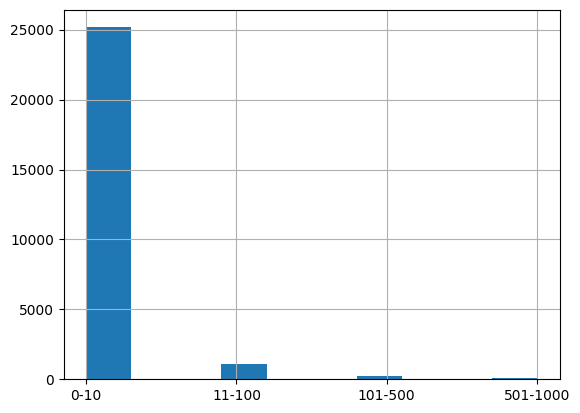

In [77]:
depp_comments['Likes'].hist()

<Axes: >

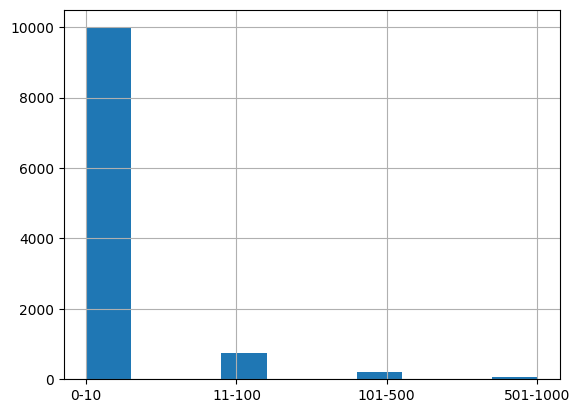

In [78]:
ceo_comments['Likes'].hist()

<Axes: >

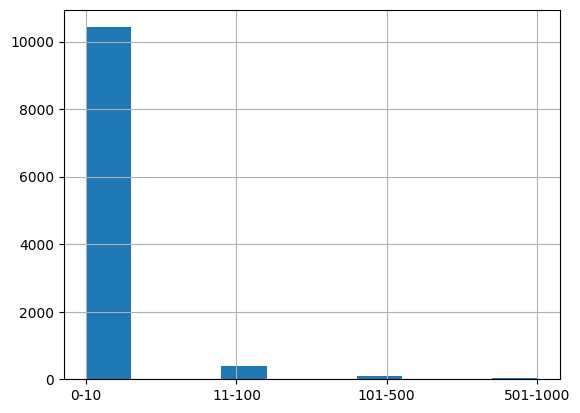

In [79]:
assad_comments['Likes'].hist()

<h3>Number of Comments by size performed by overall group and separated channels</h3>

<Axes: >

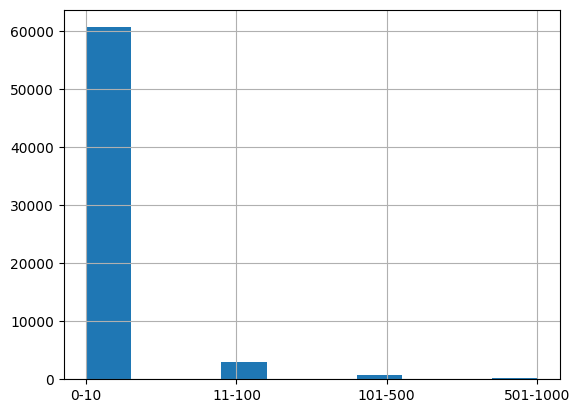

In [80]:
capitol_comments['Likes'].hist()

In [81]:
assad_comments.head()

,Comment,Likes,channel,leaning
0,bbc journalists must go to the doors of britis...,0-10,bbc,news
1,getting out of hands. it may sound off topic b...,0-10,bbc,news
2,imperialist go home,0-10,bbc,news
3,it's like we've seen this movie in the middle ...,0-10,bbc,news
4,😂😂😂 how dumb and foolish the americans and the...,0-10,bbc,news


In [82]:
analyser = SentimentIntensityAnalyzer()

<Axes: title={'center': 'Assad Fall Topic distribution'}, xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments'>

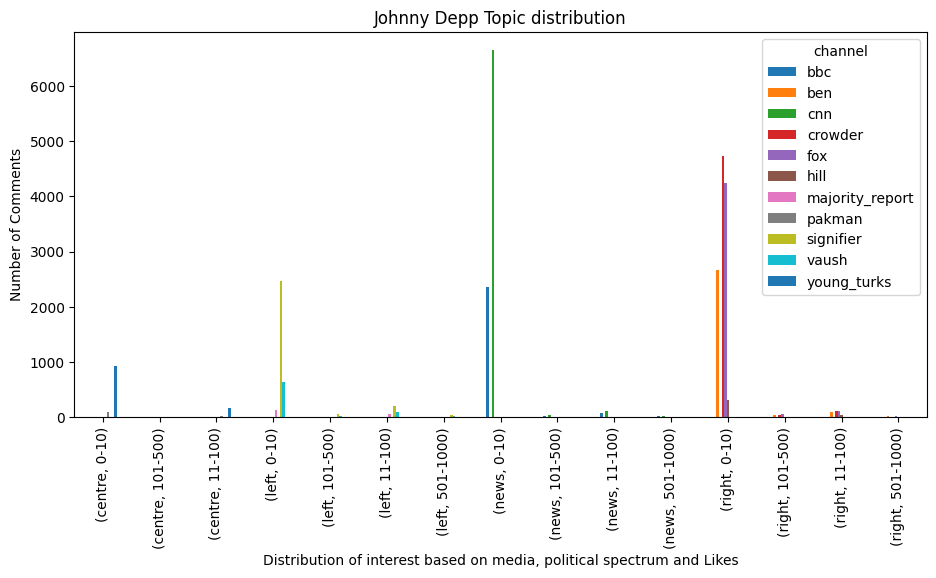

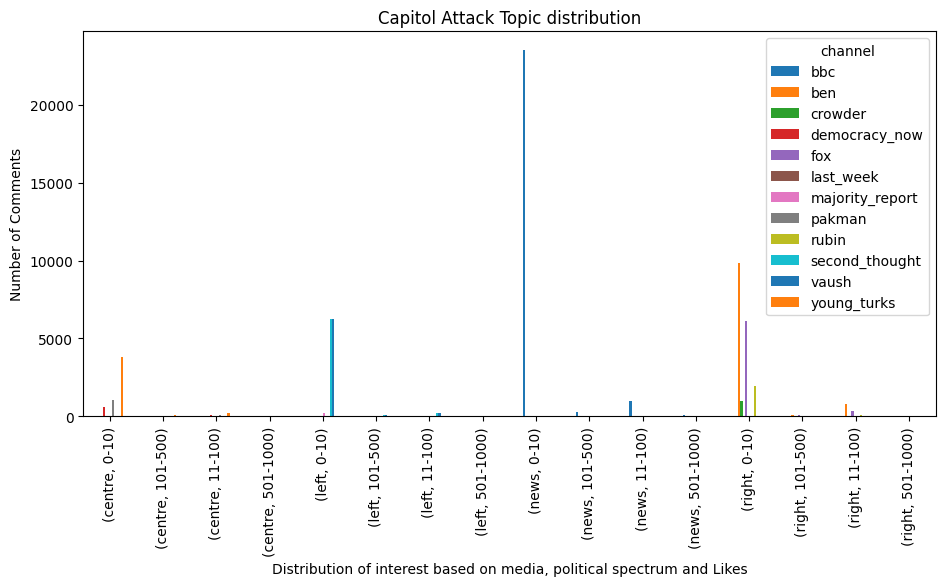

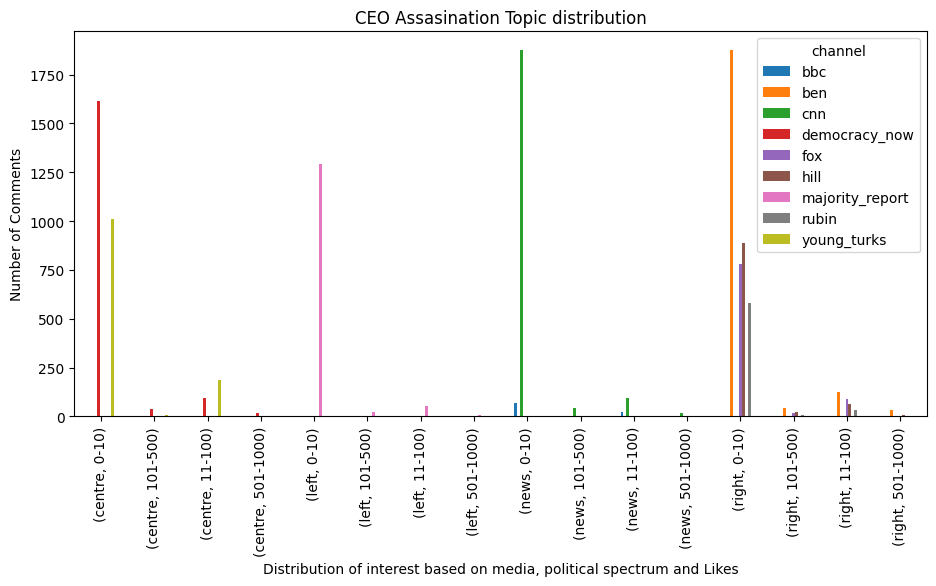

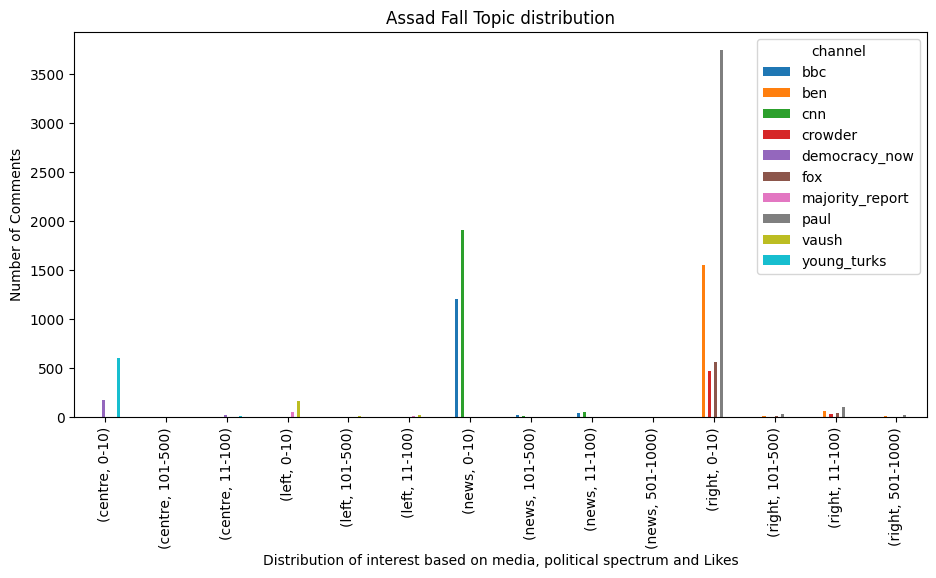

In [83]:
depp_comments.groupby(['leaning', 'Likes', 'channel']).size().unstack().plot(kind='bar',figsize=(11, 5), title='Johnny Depp Topic distribution', xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments')

capitol_comments.groupby(['leaning', 'Likes', 'channel']).size().unstack().plot(kind='bar',figsize=(11, 5), title='Capitol Attack Topic distribution', xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments')

ceo_comments.groupby(['leaning', 'Likes', 'channel']).size().unstack().plot(kind='bar',figsize=(11, 5), title='CEO Assasination Topic distribution', xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments')

assad_comments.groupby(['leaning', 'Likes', 'channel']).size().unstack().plot(kind='bar',figsize=(11, 5), title='Assad Fall Topic distribution', xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments')

<Axes: title={'center': 'Assad Fall Leaning against Channel Topic distribution'}, xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments'>

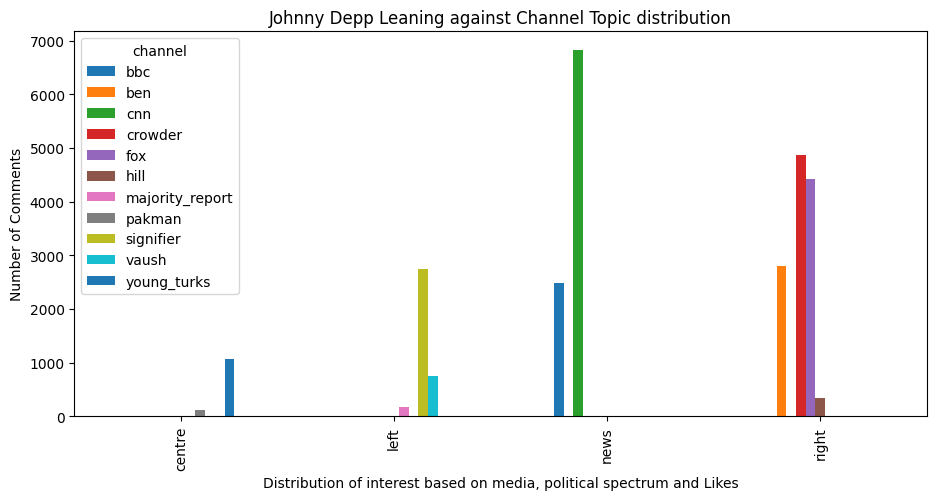

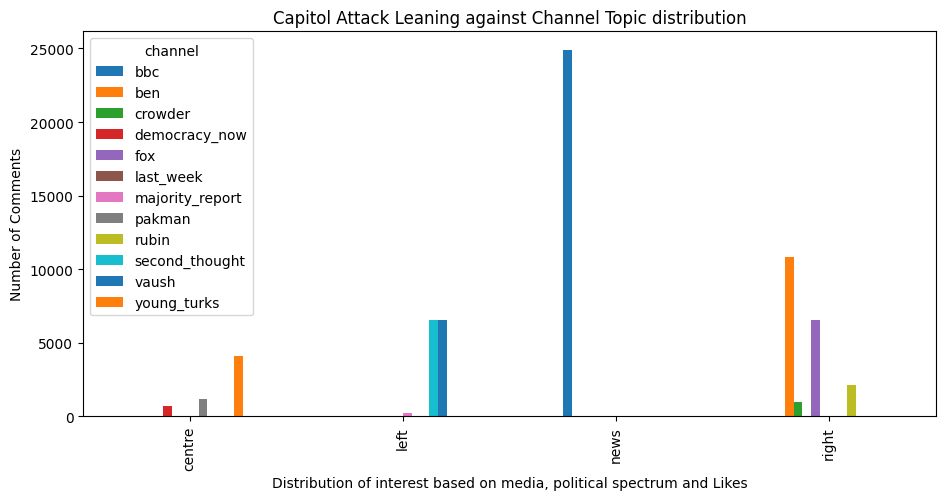

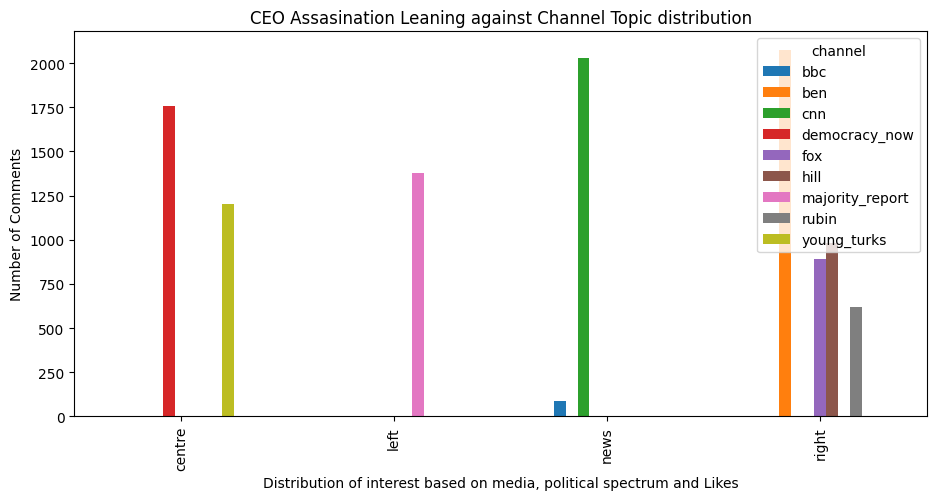

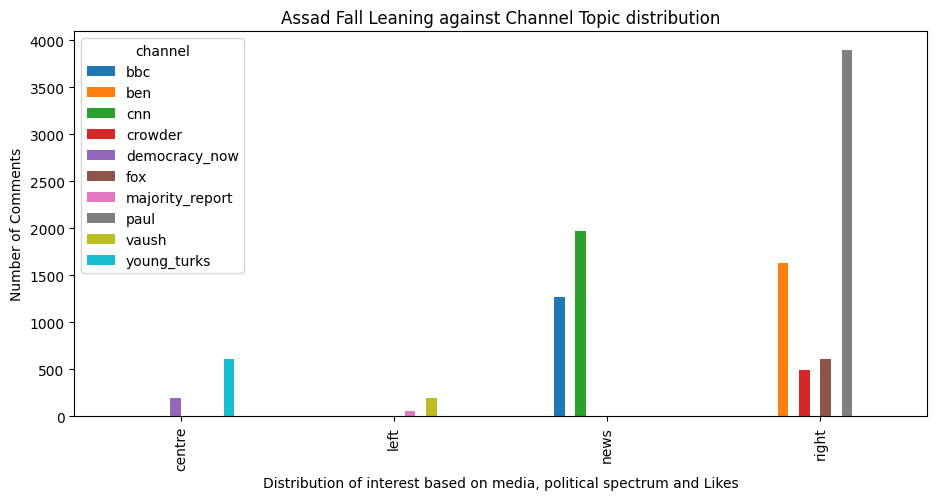

In [84]:
depp_comments.groupby(['leaning', 'channel']).size().unstack().plot(kind='bar',figsize=(11, 5), title='Johnny Depp Leaning against Channel Topic distribution', xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments')

capitol_comments.groupby(['leaning', 'channel']).size().unstack().plot(kind='bar',figsize=(11, 5), title='Capitol Attack Leaning against Channel Topic distribution', xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments')

ceo_comments.groupby(['leaning', 'channel']).size().unstack().plot(kind='bar',figsize=(11, 5), title='CEO Assasination Leaning against Channel Topic distribution', xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments')

assad_comments.groupby(['leaning', 'channel']).size().unstack().plot(kind='bar',figsize=(11, 5), title='Assad Fall Leaning against Channel Topic distribution', xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments')


<h2>NLP Polarization Topic Modeling</h2>

Polarization of opinion by media using polarity score. It captures distribution of interest in form of numbers in range of -1 to 1 where -1 stands for purely negative position, 0 for neutral position and 1 for purely positive position.

In [85]:
def calculate_polarity_scores(data: pd.DataFrame):
    compval1 = [ ] # empty list to hold our computed 'compound' VADER scores
    i=0 # counter

    while (i<len(data)):

        k = analyser.polarity_scores(data.iloc[i]['Comment'])
        compval1.append(k['compound'])
        
        i = i+1
        
    # convert sentiment values to numpy for easier usage
    compval1 = np.array(compval1)
    print(len(compval1))
    print(compval1[0])
    data['Polarity_scores'] = compval1

calculate_polarity_scores(assad_comments)
calculate_polarity_scores(ceo_comments)
calculate_polarity_scores(capitol_comments)
calculate_polarity_scores(depp_comments)

10949
-0.8217
11022
0.1779
64683
-0.6983
26612
-0.8858


In [86]:
ceo_comments

,Comment,Likes,channel,leaning,Polarity_scores
3237,well he was stressed out so of course he went ...,0-10,cnn,news,0.1779
3238,police were being forceful with him . luig...,0-10,cnn,news,-0.4545
3239,nullify nullify \nfree luigi,0-10,cnn,news,0.5106
3240,i am sad!! wish him well!!,0-10,cnn,news,0.4344
3241,hope we can save luigi.,0-10,cnn,news,0.7269
...,...,...,...,...,...
108094,his hoodie was a mid tone hue that's why it lo...,0-10,young_turks,centre,0.0000
108095,_“those who make peaceful revolution impossibl...,11-100,young_turks,centre,-0.5106
108096,"so young, so handsome, and an ivy league compu...",0-10,young_turks,centre,-0.1416
108097,"i'm tellin' y'all, that's not luigi! that's su...",11-100,young_turks,centre,0.0000


In [87]:
# assign score categories and logic
global i

def predict_sentiment(data: pd.DataFrame):
    i = 0
    predicted_value = [ ] # empty series to hold our predicted values

    while(i<len(data)):
        if ((data.iloc[i]['Polarity_scores'] >= 0.7)):
            predicted_value.append('positive')
            i = i+1
        elif ((data.iloc[i]['Polarity_scores'] > 0) & (data.iloc[i]['Polarity_scores'] < 0.7)):
            predicted_value.append('neutral')
            i = i+1
        elif ((data.iloc[i]['Polarity_scores'] <= 0)):
            predicted_value.append('negative')
            i = i+1

    data['predicted sentiment'] = predicted_value

predict_sentiment(assad_comments)
predict_sentiment(ceo_comments)
predict_sentiment(capitol_comments)
predict_sentiment(depp_comments)

In [88]:
ceo_comments

,Comment,Likes,channel,leaning,Polarity_scores,predicted sentiment
3237,well he was stressed out so of course he went ...,0-10,cnn,news,0.1779,neutral
3238,police were being forceful with him . luig...,0-10,cnn,news,-0.4545,negative
3239,nullify nullify \nfree luigi,0-10,cnn,news,0.5106,neutral
3240,i am sad!! wish him well!!,0-10,cnn,news,0.4344,neutral
3241,hope we can save luigi.,0-10,cnn,news,0.7269,positive
...,...,...,...,...,...,...
108094,his hoodie was a mid tone hue that's why it lo...,0-10,young_turks,centre,0.0000,negative
108095,_“those who make peaceful revolution impossibl...,11-100,young_turks,centre,-0.5106,negative
108096,"so young, so handsome, and an ivy league compu...",0-10,young_turks,centre,-0.1416,negative
108097,"i'm tellin' y'all, that's not luigi! that's su...",11-100,young_turks,centre,0.0000,negative


<h3>Distribution of Sentiment Type by CEO Assassination Topic</h3>

The opinions remain mostly negative with over 65% of negative response.

Text(0.5, 1.0, 'CEO Sentiment Type')

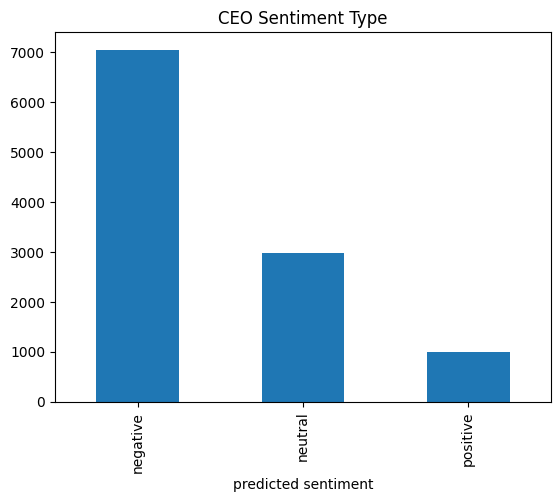

In [89]:
ceo_plot = ceo_comments.groupby('predicted sentiment').size().plot(kind='bar')
ceo_plot.set_title('CEO Sentiment Type')

<h3>Distribution of Sentiment Type by Capitol Attack Topic</h3>

The opinions remain negative with over 60% of negative response.

Text(0.5, 1.0, 'Capitol Sentiment Type')

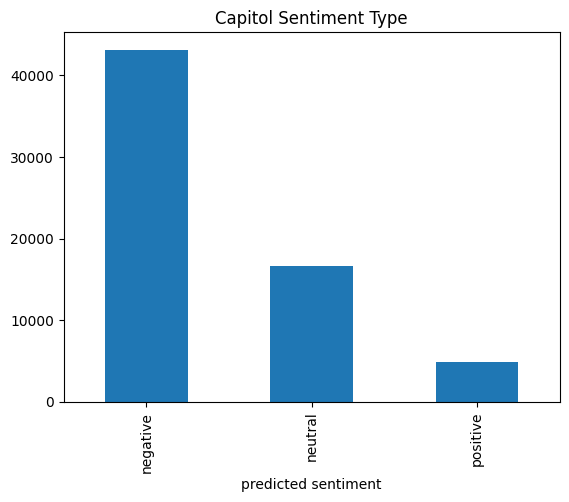

In [90]:
capitol_plot = capitol_comments.groupby('predicted sentiment').size().plot(kind='bar')
capitol_plot.set_title('Capitol Sentiment Type')

<h3>Distribution of Sentiment Type by Assad Fall Topic</h3>

The opinions remain mostly negative/neutral with 50% of negative response.

Text(0.5, 1.0, 'Assad Sentiment Type')

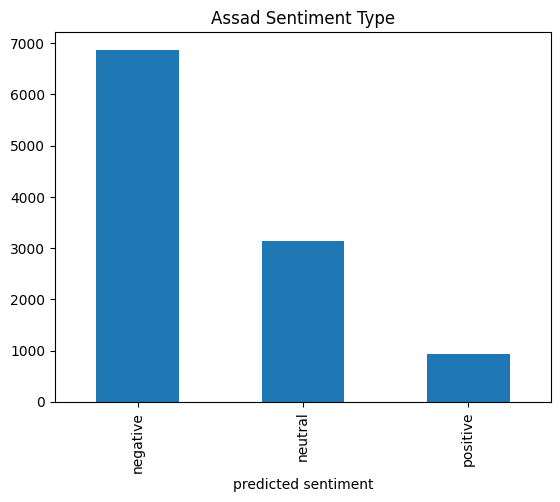

In [91]:
assad_plot = assad_comments.groupby('predicted sentiment').size().plot(kind='bar')
assad_plot.set_title('Assad Sentiment Type')

<h3>Distribution of Sentiment Type by Johnny Depp Trial Topic</h3>

The opinions remain negative with over 60% of negative response.

Text(0.5, 1.0, 'Depp Sentiment Type')

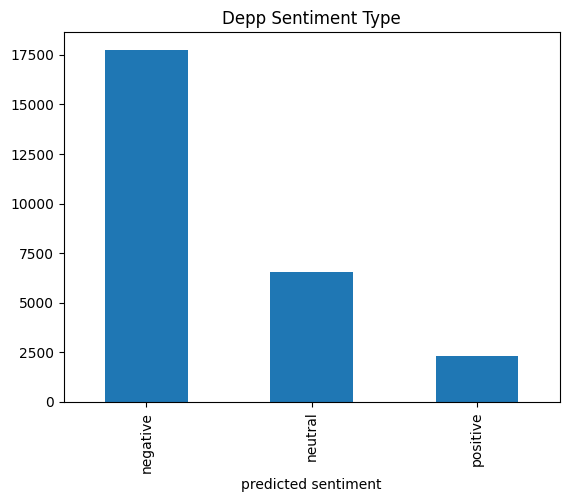

In [92]:
depp_plot = depp_comments.groupby('predicted sentiment').size().plot(kind='bar')
depp_plot.set_title('Depp Sentiment Type')

In [93]:
from wordcloud import WordCloud,STOPWORDS

<h3>Distribution of Sentiment by channel and sentiment leaning</h3>

The opinions show high variance on different channels among responses.

<Axes: title={'center': 'Assad Fall Leaning against Channel Topic distribution'}, xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments'>

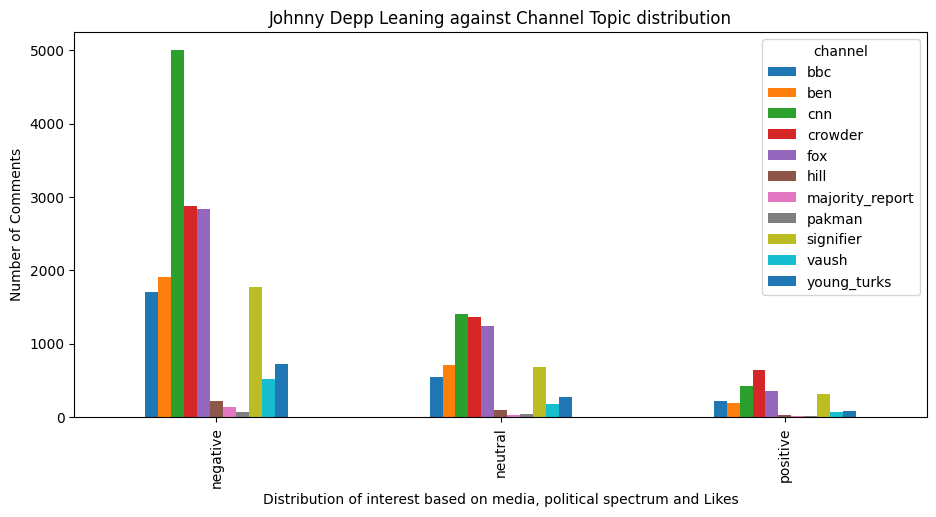

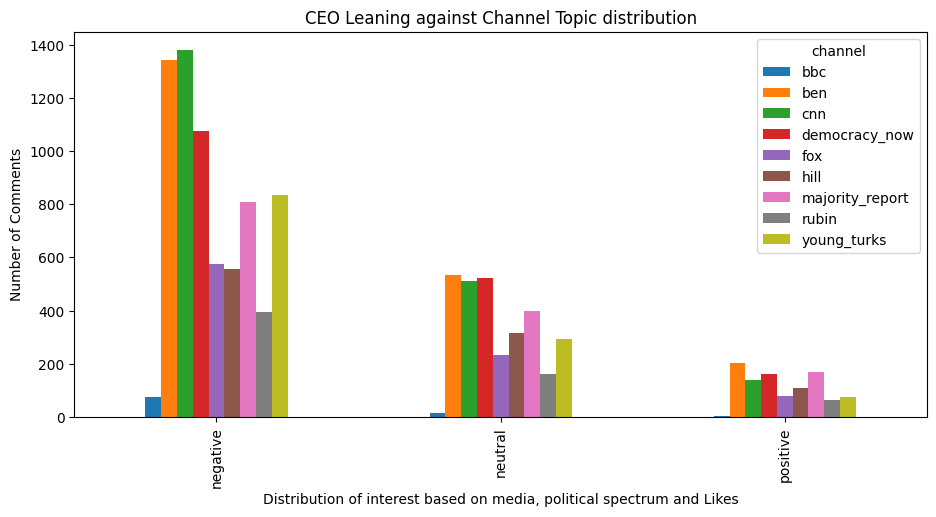

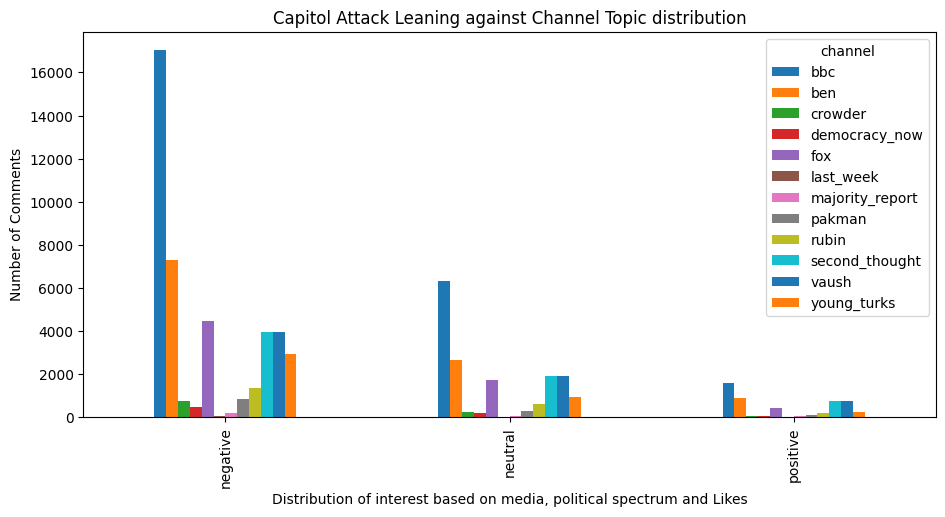

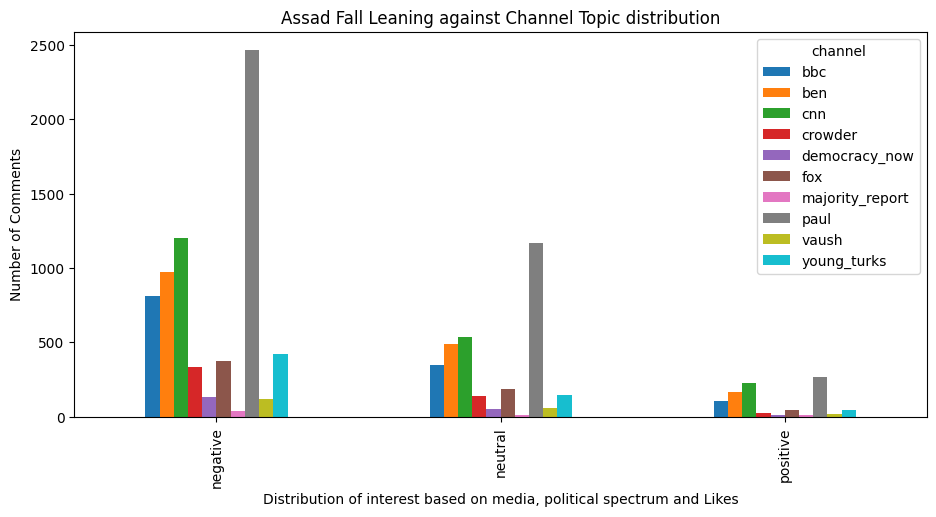

In [94]:
depp_comments.groupby(['predicted sentiment', 'channel']).size().unstack().plot(kind='bar',figsize=(11, 5), title='Johnny Depp Leaning against Channel Topic distribution', xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments')
ceo_comments.groupby(['predicted sentiment', 'channel']).size().unstack().plot(kind='bar',figsize=(11, 5), title='CEO Leaning against Channel Topic distribution', xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments')
capitol_comments.groupby(['predicted sentiment', 'channel']).size().unstack().plot(kind='bar',figsize=(11, 5), title='Capitol Attack Leaning against Channel Topic distribution', xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments')
assad_comments.groupby(['predicted sentiment', 'channel']).size().unstack().plot(kind='bar',figsize=(11, 5), title='Assad Fall Leaning against Channel Topic distribution', xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments')


In [95]:
def get_top_keywords(data, sentiment):
    stop_words = set(stopwords.words('english'))
    comments = data[data['predicted sentiment'] == sentiment]['Comment']
    all_words = ' '.join(comments).lower()
    words = word_tokenize(all_words)
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
    word_counts = Counter(filtered_words)
    top_keywords = word_counts.most_common(40)
    return top_keywords

channels = ['depp_comments', 'ceo_comments', 'capitol_comments', 'assad_comments']
sentiments = ['negative', 'neutral', 'positive']

for channel in channels:
    data = globals()[channel]
    print(f"Top 40 keywords for {channel}:")
    for sentiment in sentiments:
        keywords = get_top_keywords(data, sentiment)
        print(f"\n{sentiment.capitalize()} comments:")
        for word, count in keywords:
            print(f"{word}: {count}")


Top 40 keywords for depp_comments:

Negative comments:
amber: 5382
women: 3637
heard: 3488
depp: 3031
johnny: 2906
trial: 2798
abuse: 2686
people: 2607
woman: 2345
men: 2302
evidence: 2247
like: 2183
one: 2077
case: 2062
cnn: 1869
get: 1813
even: 1809
would: 1802
victim: 1532
man: 1516
believe: 1512
abused: 1368
think: 1340
know: 1311
victims: 1283
never: 1228
abuser: 1211
see: 1151
got: 1148
time: 1143
watch: 1140
lies: 1101
also: 1083
right: 999
back: 994
really: 989
said: 985
say: 981
jury: 977
lied: 962

Neutral comments:
amber: 1112
like: 1044
depp: 795
johnny: 787
women: 743
trial: 723
people: 717
heard: 716
get: 539
would: 517
woman: 515
cnn: 492
one: 486
men: 483
case: 474
think: 406
evidence: 397
even: 382
man: 355
watch: 332
see: 329
never: 329
truth: 327
know: 322
want: 312
good: 305
time: 298
right: 285
really: 278
video: 275
believe: 273
marriage: 272
lol: 267
got: 266
media: 262
jury: 261
justice: 255
way: 253
said: 251
court: 247

Positive comments:
like: 797
people: 644

In [96]:
import pandas as pd
import random
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the VADER lexicon and stopwords
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

# Initialize the VADER sentiment analyzer
analyser = SentimentIntensityAnalyzer()

# Function to get top 50 unique keywords for each sentiment
def get_unique_keywords(data, sentiment):
    stop_words = set(stopwords.words('english'))
    comments = data[data['predicted sentiment'] == sentiment]['Comment']
    all_words = ' '.join(comments).lower()
    words = word_tokenize(all_words)
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
    word_counts = Counter(filtered_words)
    top_keywords = word_counts.most_common(50)
    return set([word for word, count in top_keywords])

# Function to get unique keywords for each sentiment
def get_sentiment_keywords(data):
    negative_keywords = get_unique_keywords(data, 'negative')
    neutral_keywords = get_unique_keywords(data, 'neutral')
    positive_keywords = get_unique_keywords(data, 'positive')

    unique_negative = negative_keywords - neutral_keywords - positive_keywords
    unique_neutral = neutral_keywords - negative_keywords - positive_keywords
    unique_positive = positive_keywords - negative_keywords - neutral_keywords

    return unique_negative, unique_neutral, unique_positive

# Assuming your data is in DataFrames called depp_comments, ceo_comments, capitol_comments, and assad_comments
channels = ['depp_comments', 'ceo_comments', 'capitol_comments', 'assad_comments']

for channel in channels:
    data = globals()[channel]
    unique_negative, unique_neutral, unique_positive = get_sentiment_keywords(data)
    print(f"Top 50 unique keywords for {channel}:")
    print(f"\nNegative comments: {list(unique_negative)[:50]}")
    print(f"\nNeutral comments: {list(unique_neutral)[:50]}")
    print(f"\nPositive comments: {list(unique_positive)[:50]}")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\X\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\X\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\X\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Top 50 unique keywords for depp_comments:

Negative comments: ['go', 'abused', 'going', 'victim', 'lying', 'victims', 'wrong', 'abuse', 'domestic', 'lies', 'lied', 'abuser', 'still']

Neutral comments: ['video', 'lol', 'money', 'thank']

Positive comments: ['life', 'married', 'god', 'great', 'always', 'years', 'need']
Top 50 unique keywords for ceo_comments:

Negative comments: ['company', 'murder', 'take', 'person', 'someone', 'pain', 'back', 'denied', 'wrong', 'violence', 'bad']

Neutral comments: ['americans', 'trump']

Positive comments: ['really', 'government', 'great', 'country', 'best', 'love']
Top 50 unique keywords for capitol_comments:

Negative comments: ['democrats', 'war', 'years', 'many', 'let', 'capital', 'news', 'violence', 'fraud', 'evidence', 'day']

Neutral comments: ['lol', 'peaceful']

Positive comments: ['ha', 'also', 'god', 'republican', 'states', 'better', 'freedom']
Top 50 unique keywords for assad_comments:

Negative comments: ['terrorists', 'dictator', 'islam

<Axes: title={'center': 'Assad Fall Leaning against sentiment Topic distribution'}, xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments'>

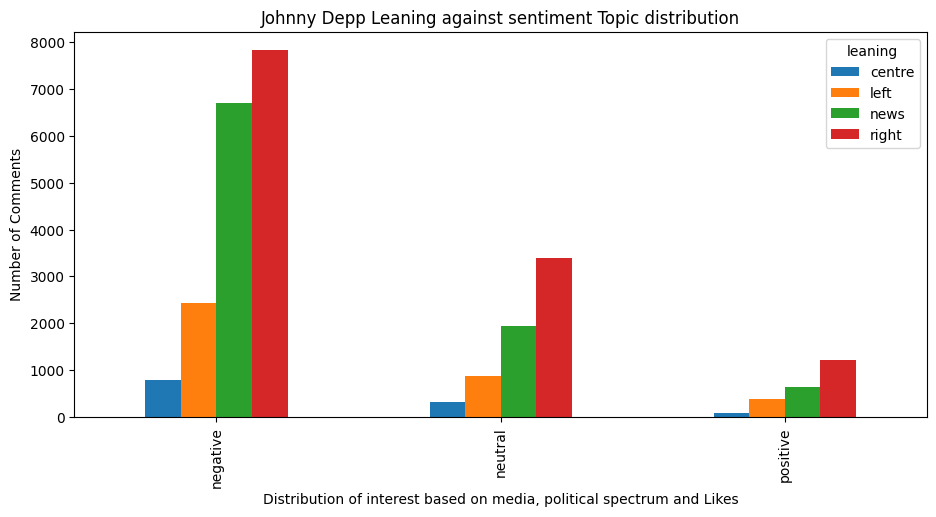

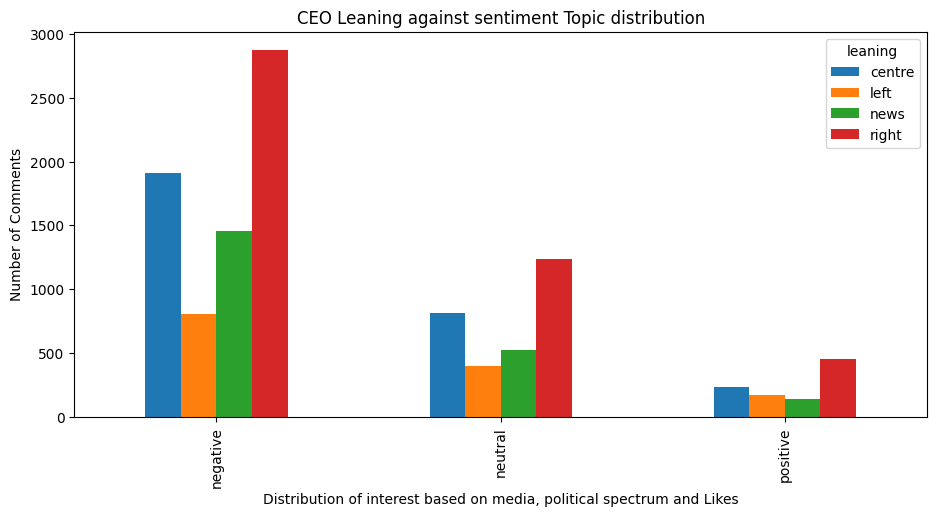

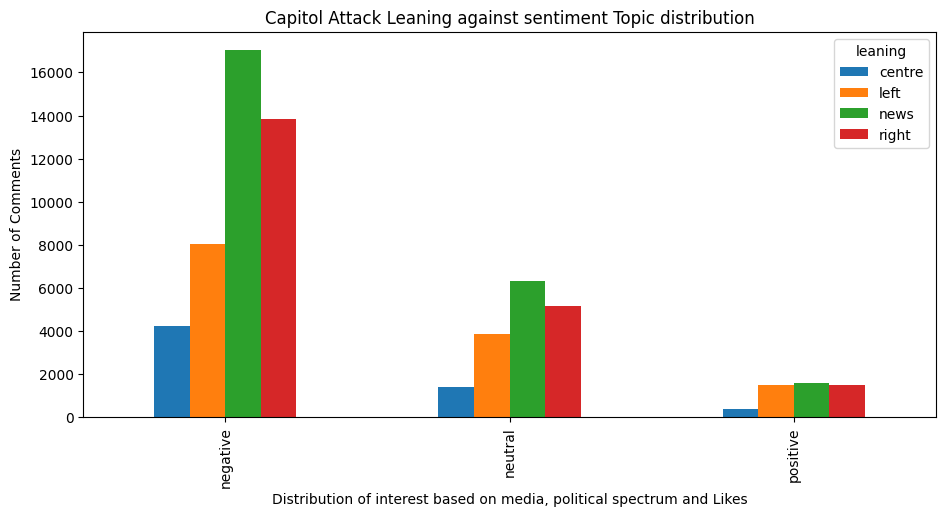

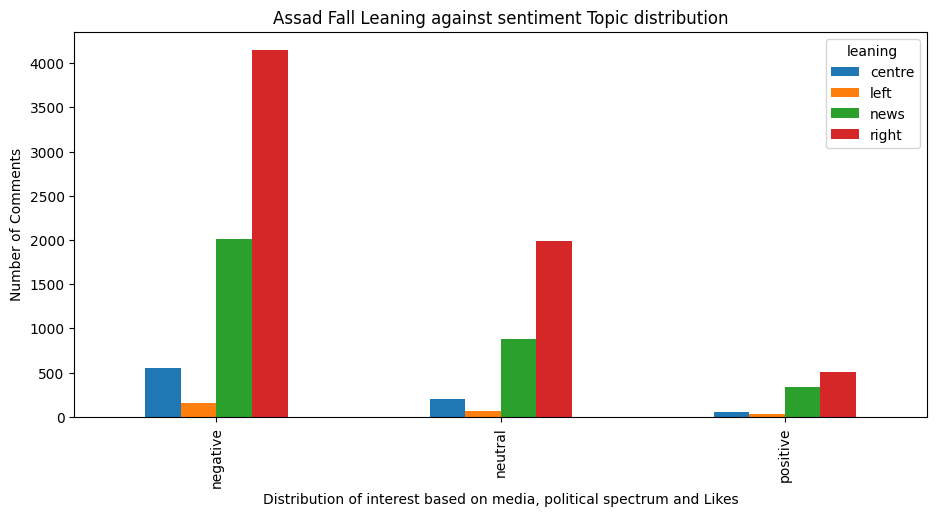

In [97]:
depp_comments.groupby(['predicted sentiment', 'leaning']).size().unstack().plot(kind='bar',figsize=(11, 5), title='Johnny Depp Leaning against sentiment Topic distribution', xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments')
ceo_comments.groupby(['predicted sentiment', 'leaning']).size().unstack().plot(kind='bar',figsize=(11, 5), title='CEO Leaning against sentiment Topic distribution', xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments')
capitol_comments.groupby(['predicted sentiment', 'leaning']).size().unstack().plot(kind='bar',figsize=(11, 5), title='Capitol Attack Leaning against sentiment Topic distribution', xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments')
assad_comments.groupby(['predicted sentiment', 'leaning']).size().unstack().plot(kind='bar',figsize=(11, 5), title='Assad Fall Leaning against sentiment Topic distribution', xlabel='Distribution of interest based on media, political spectrum and Likes', ylabel='Number of Comments')

In [98]:
import sklearn

In [99]:
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem

In [100]:
def clean_comment(comment, bigrams=False):
    comment = comment.lower() # lower case
    comment = re.sub('['+my_punctuation + ']+', ' ', comment) # strip punctuation
    comment = re.sub('\s+', ' ', comment) #remove double spacing
    comment = re.sub('([0-9]+)', '', comment) # remove numbers
    comment_token_list = [word for word in comment.split(' ')
                            if word not in my_stopwords] # remove stopwords

    comment_token_list = [word_rooter(word) if '#' not in word else word
                        for word in comment_token_list] # apply word rooter
    if bigrams:
        comment_token_list = comment_token_list+[comment_token_list[i]+'_'+ comment_token_list[i+1]
                                            for i in range(len(comment_token_list)-1)]
    comment = ' '.join(comment_token_list)
    return comment

In [101]:
depp_comments['clean_comment'] = depp_comments.Comment.apply(clean_comment)
ceo_comments['clean_comment'] = ceo_comments.Comment.apply(clean_comment)
capitol_comments['clean_comment'] = capitol_comments.Comment.apply(clean_comment)
assad_comments['clean_comment'] = assad_comments.Comment.apply(clean_comment)
assad_comments.head()

,Comment,Likes,channel,leaning,Polarity_scores,predicted sentiment,clean_comment
0,bbc journalists must go to the doors of britis...,0-10,bbc,news,-0.8217,negative,bbc journalist must go door british nato base ...
1,getting out of hands. it may sound off topic b...,0-10,bbc,news,0.9235,positive,get hand may sound topic chanc cool translat e...
2,imperialist go home,0-10,bbc,news,0.0000,negative,imperialist go home
3,it's like we've seen this movie in the middle ...,0-10,bbc,news,0.7783,positive,like seen movi middl east play let hope coher ...
4,😂😂😂 how dumb and foolish the americans and the...,0-10,bbc,news,-0.7184,negative,😂😂😂 dumb foolish american west trap like happe...


In [102]:
from sklearn.feature_extraction.text import CountVectorizer

In [103]:
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

In [104]:
# apply transformation
tf_assad = vectorizer.fit_transform(assad_comments['clean_comment']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_assad_feature_names = vectorizer.get_feature_names_out()

In [105]:
from sklearn.decomposition import LatentDirichletAllocation

In [106]:
# let us assume 10 topics
number_of_topics = 10

<h3>Topic Modeling by LDA algorithm</h3>

We are trying to figure out 10 most important topics.

In [107]:
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
# apply the model
model.fit(tf_assad)

LatentDirichletAllocation(random_state=0)

In [108]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

<h3>Topics weights based on multiple words</h3>

The topic weights show how common and impactful are the occurrences of different words.

In [109]:
no_top_words = 10


In [110]:
# apply transformation
tf_depp = vectorizer.fit_transform(depp_comments['clean_comment']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_depp_feature_names = vectorizer.get_feature_names_out()

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
# apply the model
model.fit(tf_depp)

no_top_words = 10
display_topics(model, tf_depp_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,like,1820.6,men,1369.4,’,3105.6,cnn,2537.6,ah,797.9,abus,5678.5,depp,2436.3,evid,1942.1,watch,946.5,get,1103.4
1,peopl,842.9,women,1342.1,’t,2885.1,news,936.3,jd,670.1,amber,3093.9,johnni,1913.5,trial,1839.9,trial,795.1,go,920.7
2,know,822.4,marriag,1177.7,it,986.1,lie,712.1,women,491.5,victim,2510.3,heard,1278.7,juri,1211.6,video,790.8,money,843.7
3,love,697.8,get,1090.6,i,930.9,watch,700.9,elain,477.5,heard,2125.3,men,1128.5,case,1129.2,peopl,429.6,hit,686.6
4,shit,651.7,peopl,782.5,don,753.0,media,658.2,accus,320.9,lie,1892.8,win,1057.3,watch,1100.8,lol,429.4,pay,683.7
5,amber,633.7,man,781.8,”,736.3,amber,649.0,fals,290.3,women,1857.0,amber,1017.8,amber,1020.1,like,414.4,johnni,659.1
6,realli,631.8,marri,767.8,…,725.6,truth,439.7,lie,279.3,believ,1560.7,women,957.3,lie,939.1,talk,401.8,want,627.9
7,thing,553.9,woman,721.4,’m,594.1,trial,436.3,amber,252.6,johnni,1147.4,case,822.5,uk,913.9,thank,352.2,would,616.5
8,guy,523.8,want,652.3,didn,593.1,liar,388.7,need,210.7,depp,1022.2,abus,804.7,judg,755.5,care,329.6,time,563.2
9,think,482.6,abus,597.0,she,563.0,fake,313.6,woman,204.7,evid,953.4,victim,682.8,bbc,709.3,comment,303.4,got,559.7


In [111]:
# apply transformation
tf_ceo = vectorizer.fit_transform(ceo_comments['clean_comment']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_ceo_feature_names = vectorizer.get_feature_names_out()

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
# apply the model
model.fit(tf_ceo)

no_top_words = 10
display_topics(model, tf_ceo_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,healthcar,751.8,’t,406.5,insur,1537.4,’,1162.7,ceo,719.5,trump,347.4,ben,659.5,luigi,731.7,care,355.4,like,765.7
1,system,576.8,i,310.1,compani,885.1,’t,687.6,murder,548.8,xd,280.5,right,587.5,free,425.4,american,257.7,look,404.6
2,peopl,537.8,…,227.5,health,884.9,it,432.8,peopl,492.5,guy,164.0,left,484.0,mangion,229.2,us,236.7,guy,294.7
3,countri,288.2,’m,218.1,care,722.7,don,294.3,kill,388.3,peopl,159.8,peopl,261.4,back,205.8,health,229.8,say,234.7
4,us,251.3,guy,153.0,healthcar,636.9,peopl,175.5,man,310.4,stop,133.7,shapiro,204.2,go,188.5,work,210.8,show,229.7
5,chang,219.4,’r,152.8,deni,555.3,he,163.5,famili,284.9,think,118.6,issu,168.8,pain,141.5,peopl,205.6,one,227.8
6,corrupt,214.3,know,126.1,pay,534.8,that,161.5,mani,219.9,tri,117.6,us,152.4,get,135.5,make,188.9,thing,197.5
7,govern,209.0,don,124.7,medic,461.2,insur,141.8,one,219.3,u,116.8,rich,151.3,mental,113.5,money,177.5,know,196.3
8,america,193.1,”,111.6,peopl,450.6,care,132.9,get,202.2,want,114.8,class,150.3,peopl,94.4,system,171.1,make,184.2
9,american,190.5,😂,111.4,get,375.8,compani,121.0,death,190.8,report,105.8,media,148.3,black,84.4,healthcar,132.1,would,173.6


In [112]:
# apply transformation
tf_capitol = vectorizer.fit_transform(capitol_comments['clean_comment']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_capitol_feature_names = vectorizer.get_feature_names_out()

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
# apply the model
model.fit(tf_capitol)

no_top_words = 10
display_topics(model, tf_capitol_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,elect,3398.3,protest,2858.8,video,2425.4,trump,6286.5,peopl,3626.2,’,3445.7,america,3119.9,news,1673.0,evid,1597.3,day,1591.7
1,vote,2985.2,peopl,1954.9,right,1525.1,support,4135.7,media,1130.7,’t,3296.0,trump,2855.0,war,1194.3,trump,1399.0,ha,1407.1
2,peopl,2442.7,polic,1865.0,parti,1453.5,antifa,3591.6,countri,1090.1,trump,2310.0,world,2208.7,civil,883.7,elect,1342.5,countri,1402.8
3,biden,2241.0,white,1625.6,like,1342.9,riot,2228.2,right,1072.2,ben,2069.3,us,1841.4,fox,869.7,fraud,1196.9,like,1261.6
4,democrat,1435.6,black,1326.3,xd,988.1,blm,2098.1,american,1037.2,peopl,1769.0,countri,1783.2,year,850.6,state,1102.5,watch,1118.1
5,trump,1407.6,peac,1252.0,flag,933.1,capitol,1876.4,take,959.2,it,1361.1,presid,1563.6,start,791.4,court,951.9,democraci,1098.3
6,republican,1180.0,terrorist,1219.0,one,801.0,build,1501.2,left,958.7,like,1310.5,american,1424.2,go,741.2,coup,947.5,america,1044.3
7,would,1114.0,call,1128.2,good,781.5,peopl,1296.8,govern,957.7,i,1291.1,god,1315.4,see,708.8,ben,705.7,american,863.2
8,presid,1113.7,would,1047.9,thought,730.9,burn,1178.5,back,915.7,don,1178.1,usa,1275.2,fake,658.7,lie,676.4,worst,814.5
9,go,1073.8,blm,1011.8,left,712.6,protest,1057.0,work,872.2,say,1100.5,state,1263.5,get,652.3,bbc,565.6,lol,700.3


<h2>Cloud Words for most mentioned topics</h2>

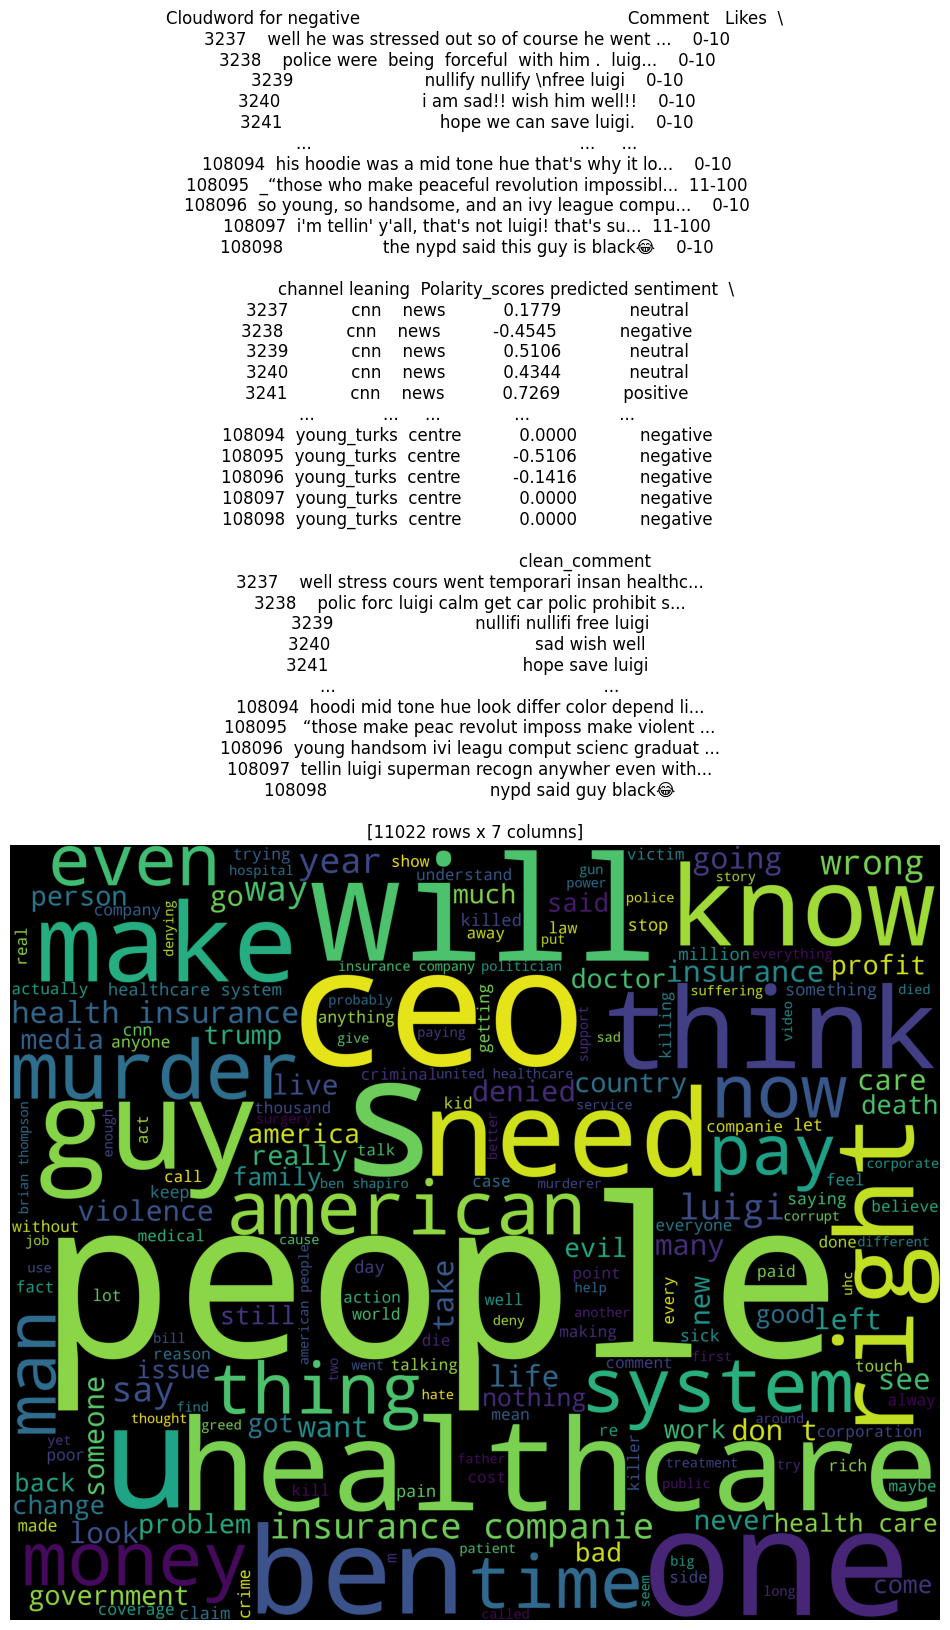

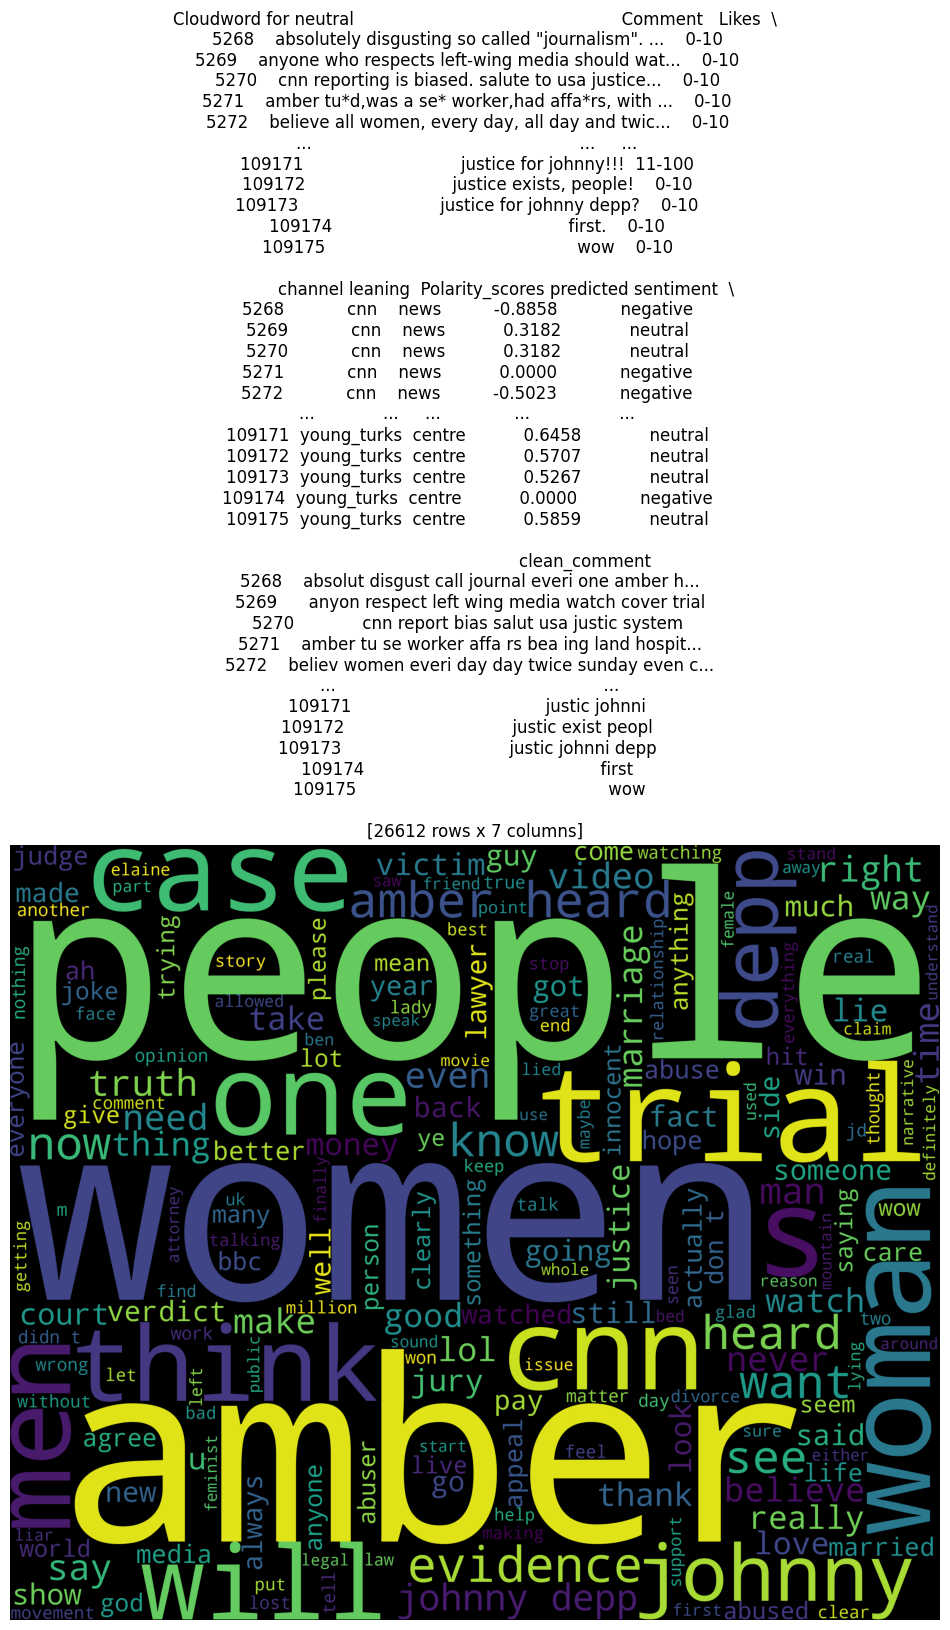

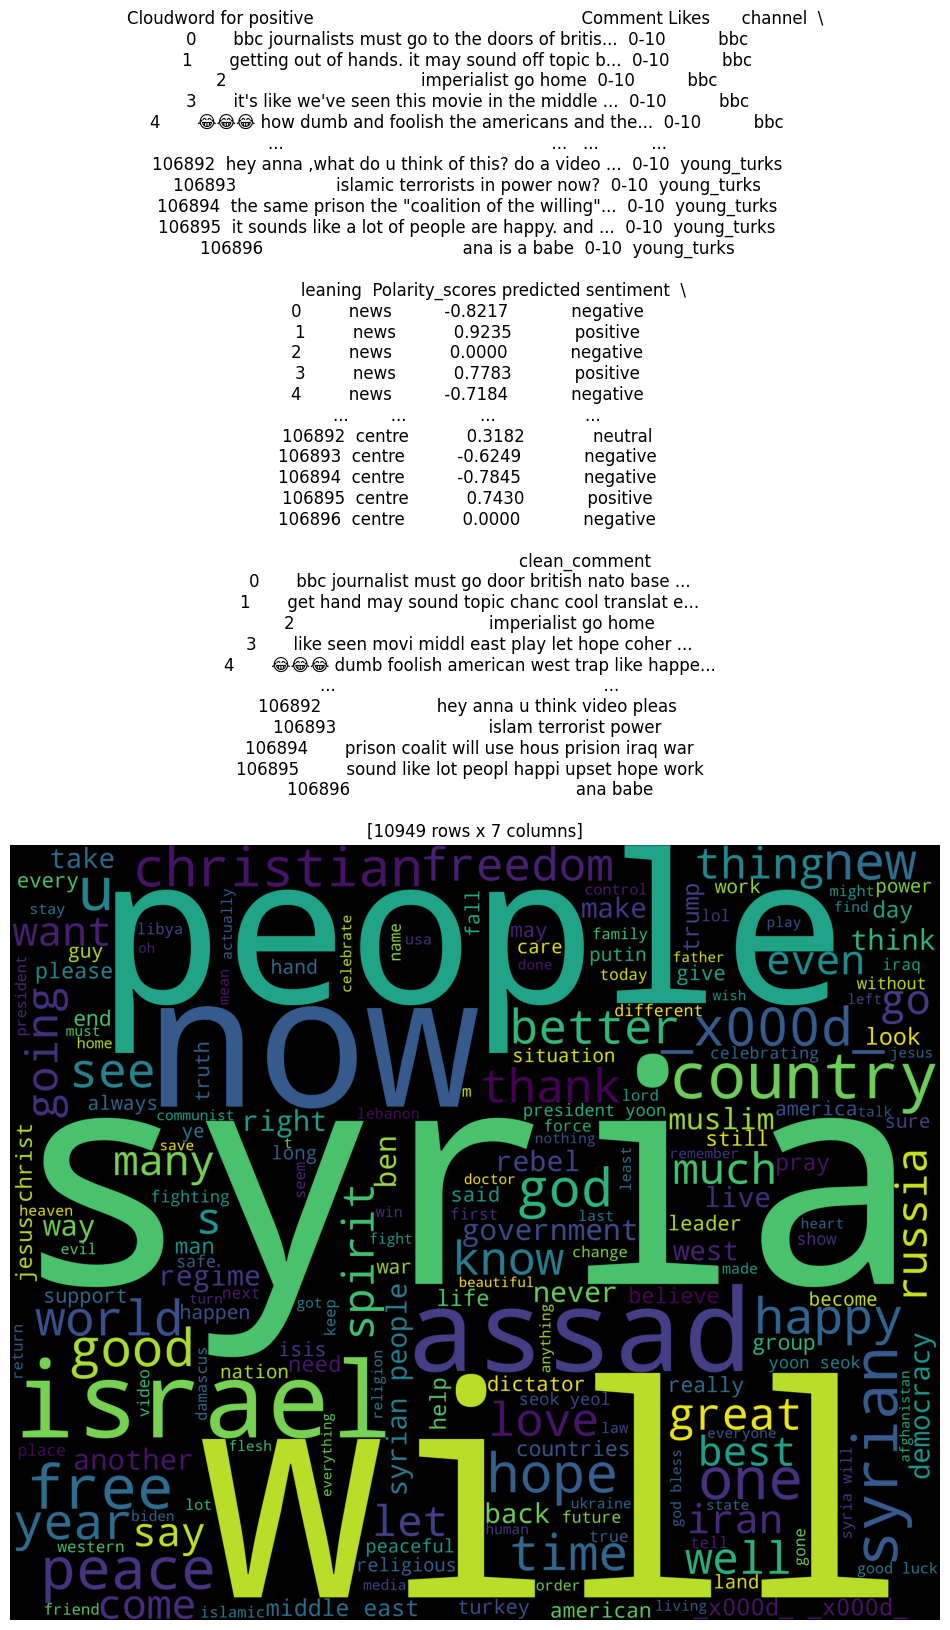

In [113]:
def generate_cloudwords(data: pd.DataFrame, sentiment: str):
    ceo_negative = data[data['predicted sentiment']==f'{sentiment}']

    words = ' '.join(ceo_negative['Comment'])
    cleaned_word = " ".join([word for word in words.split()
                                if 'http' not in word
                                    and not word.startswith('@')
                                    and word != 'RT'
                                ])

    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(stopwords=stopwords,
                        background_color='black',
                        width=3000,
                        height=2500
                        ).generate(cleaned_word)

    plt.figure(1,figsize=(12, 12))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f'Cloudword for {sentiment} {data}')
    plt.show()

generate_cloudwords(ceo_comments, 'negative')
generate_cloudwords(depp_comments, 'neutral')
generate_cloudwords(assad_comments, 'positive')
